In [1]:
import itertools as it
import os

from iterpop import iterpop as ip
import matplotlib as mpl
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: 24ab18a50f4b
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 2
nbname: spatial-nuissance-phylometrics
nbpath: /opt/hstrat-evolutionary-inference/binder/spatial-nuissance-phylometrics.ipynb
revision: null
session: f0f9c9c5-2f02-476b-a799-b6f160fca495
timestamp: 2023-05-20T23:48:40Z00:00


IPython==7.16.1
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.12.1
teeplot==0.5.0
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.0.3
json==2.0.9
six==1.16.0
ipykernel==5.5.3


In [3]:
df = pd.read_csv("https://osf.io/5trmg/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


40f23b7946d11896


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,4,...,27.305316,27.305316,1,570110,81.707306,2.677385e+06,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,41,...,26.027820,26.027820,0,548025,83.217377,2.726867e+06,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,47,...,27.705938,27.705938,0,559117,86.538544,2.835695e+06,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,15,...,28.664163,28.664163,1,583153,76.277557,2.499463e+06,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,19,...,27.416625,27.416625,0,583519,75.600433,2.477275e+06,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104994,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,24.562416,24.562416,1,3305,99.163609,3.242650e+04,282.320163,30.0,0.01,naive
104995,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,16,...,17.300466,17.300466,0,2923,1893.146789,6.190590e+05,250803.885040,100.0,0.01,rollback
104996,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,1,...,88.702783,88.702783,1,717008,5.744125,1.882235e+05,6.163179,100.0,1.00,rollback
104997,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,25.685331,25.685331,0,516453,28.659882,9.391270e+05,116.954707,3.0,1.00,naive


In [4]:
phylometrics = [
    #     'diversity',
    "colless_like_index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean_pairwise_distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean_evolutionary_distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [5]:
methodological_variables = [
    "resolution",
]


In [6]:
evolutionary_variables = [
    "num_niches",
]


In [7]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [8]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
    "tournament_size",  # only use 2
    "num_islands",  # only use 1024
]


In [9]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & (df["tournament_size"] == 2)
    & (df["num_islands"] == 1024)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1, excluded_variable

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,4,...,27.305316,27.305316,1,570110,81.707306,2677385.0,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,41,...,26.027820,26.027820,0,548025,83.217377,2726867.0,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,47,...,27.705938,27.705938,0,559117,86.538544,2835695.0,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,15,...,28.664163,28.664163,1,583153,76.277557,2499463.0,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,19,...,27.416625,27.416625,0,583519,75.600433,2477275.0,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101360,reconstructed-tree,7,np.random.exponential,32768,1024,8,0.01,3.051758e-08,32768,38,...,14.274736,14.274736,0,449491,313.221619,10263646.0,16111.276187,3.0,1.0,naive
101376,reconstructed-tree,7,np.random.exponential,32768,1024,8,0.01,3.051758e-08,32768,14,...,17.255838,17.255838,0,470110,336.758774,11034911.5,27108.474690,30.0,1.0,naive
101377,reconstructed-tree,7,np.random.exponential,32768,1024,8,0.01,3.051758e-08,32768,39,...,17.573834,17.573834,0,486074,309.332581,10136210.0,22480.165720,100.0,1.0,naive
101381,reconstructed-tree,7,np.random.exponential,32768,1024,8,0.01,3.051758e-08,32768,38,...,19.851903,19.851903,0,497072,305.019302,9994872.5,14447.708552,10.0,1.0,naive


In [10]:
# exclude extraneous variable values
df = df[(df["a"] != "consolidated-phylogeny")].copy()

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,4,...,27.305316,27.305316,1,570110,81.707306,2677385.0,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,41,...,26.027820,26.027820,0,548025,83.217377,2726867.0,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,47,...,27.705938,27.705938,0,559117,86.538544,2835695.0,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,15,...,28.664163,28.664163,1,583153,76.277557,2499463.0,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,19,...,27.416625,27.416625,0,583519,75.600433,2477275.0,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101360,reconstructed-tree,7,np.random.exponential,32768,1024,8,0.01,3.051758e-08,32768,38,...,14.274736,14.274736,0,449491,313.221619,10263646.0,16111.276187,3.0,1.0,naive
101376,reconstructed-tree,7,np.random.exponential,32768,1024,8,0.01,3.051758e-08,32768,14,...,17.255838,17.255838,0,470110,336.758774,11034911.5,27108.474690,30.0,1.0,naive
101377,reconstructed-tree,7,np.random.exponential,32768,1024,8,0.01,3.051758e-08,32768,39,...,17.573834,17.573834,0,486074,309.332581,10136210.0,22480.165720,100.0,1.0,naive
101381,reconstructed-tree,7,np.random.exponential,32768,1024,8,0.01,3.051758e-08,32768,38,...,19.851903,19.851903,0,497072,305.019302,9994872.5,14447.708552,10.0,1.0,naive


In [11]:
df["num_niches"].unique()


array([4, 1, 8])

In [12]:
df["num_islands"].unique()


array([1024])

In [13]:
df["tournament_size"].unique()


array([2])

In [14]:
df["a"].unique()


array(['collapsed-phylogeny', 'reconstructed-tree'], dtype=object)

In [15]:
df["regime"] = df.apply(
    lambda row: {
        (1024, 1, 3.0517578125e-08): "plain",
        (1024, 4, 3.0517578125e-08): "4 niche ecology",
        (1024, 4, 3.0517578125e-06): "weak 4 niche ecology",
        (1024, 8, 3.0517578125e-08): "8 niche ecology",
    }.get(
        tuple(row[["num_islands", "num_niches", "p_niche_invasion"]]),
        np.nan,  # default
    ),
    axis="columns",
)
df["regime"].unique()


array(['weak 4 niche ecology', '4 niche ecology', 'plain',
       '8 niche ecology'], dtype=object)

In [16]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['weak 4 niche ecology', '4 niche ecology', 'plain',
       '8 niche ecology'], dtype=object)

# perfect phylogenetic data


In [17]:
melted_df = df[(df["a"] == "collapsed-phylogeny")].melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


,num_niches,resolution,epoch,mut_distn,regime,variable,value,phylometric
0,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,245694.126217,colless_like_index
1,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,229733.780163,colless_like_index
2,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,233461.802088,colless_like_index
3,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,262782.396217,colless_like_index
4,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,260748.492189,colless_like_index
...,...,...,...,...,...,...,...,...
4791,4,NaN,2,np.random.exponential,weak 4 niche ecology,mean_evolutionary_distinctiveness,62.567078,mean_evolutionary_distinctiveness
4792,4,NaN,2,np.random.exponential,weak 4 niche ecology,mean_evolutionary_distinctiveness,54.291748,mean_evolutionary_distinctiveness
4793,4,NaN,2,np.random.exponential,weak 4 niche ecology,mean_evolutionary_distinctiveness,61.928589,mean_evolutionary_distinctiveness
4794,4,NaN,2,np.random.exponential,weak 4 niche ecology,mean_evolutionary_distinctiveness,65.404114,mean_evolutionary_distinctiveness


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.png
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=barplot+x=value+y=regime+ext=.pdf
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_

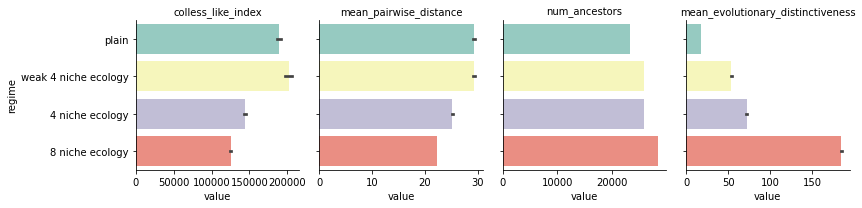

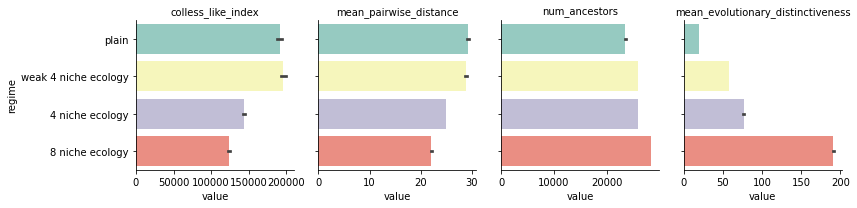

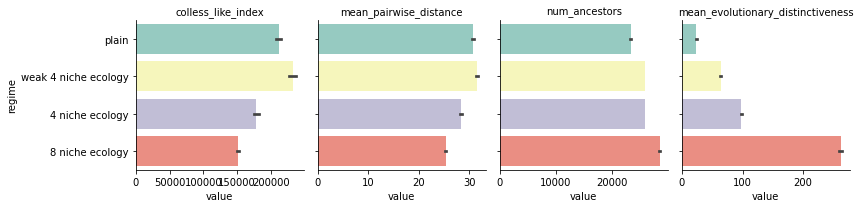

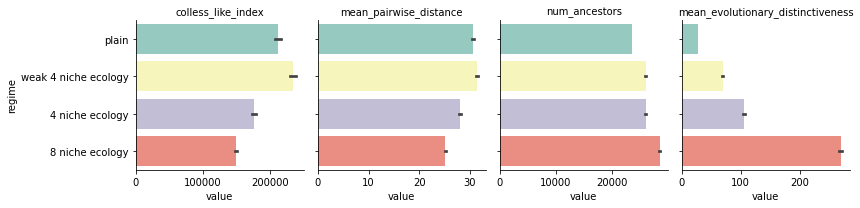

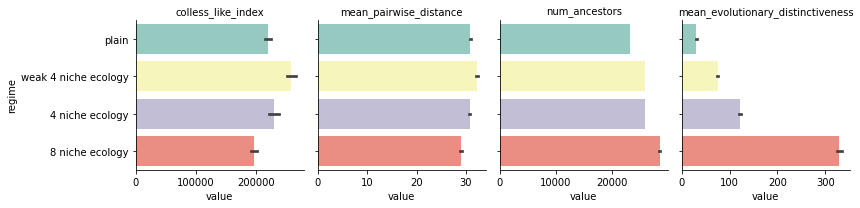

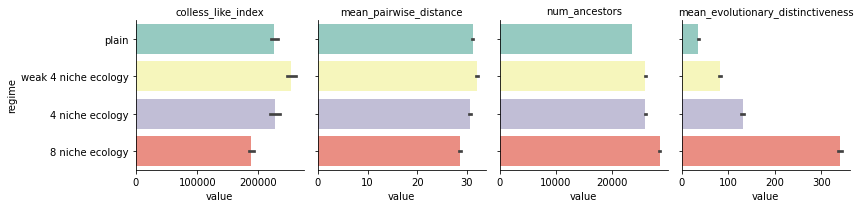

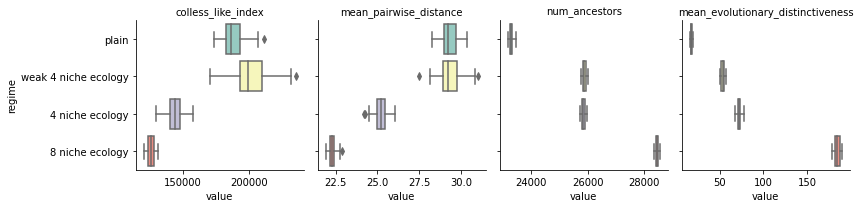

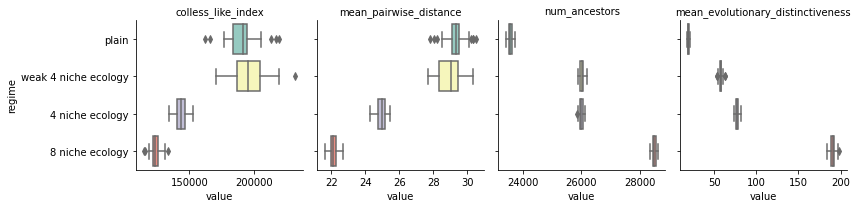

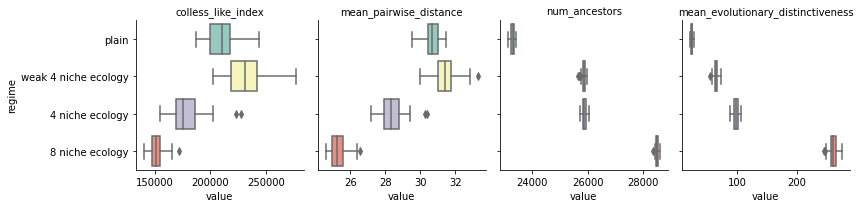

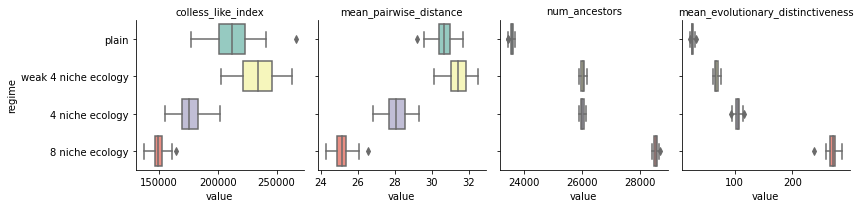

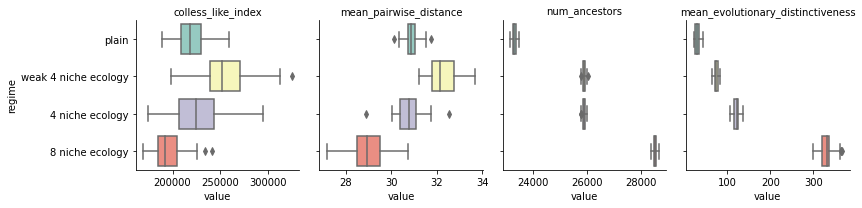

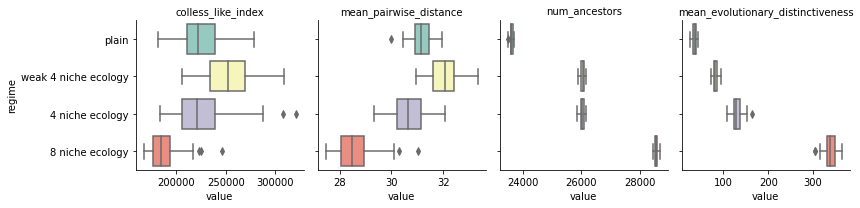

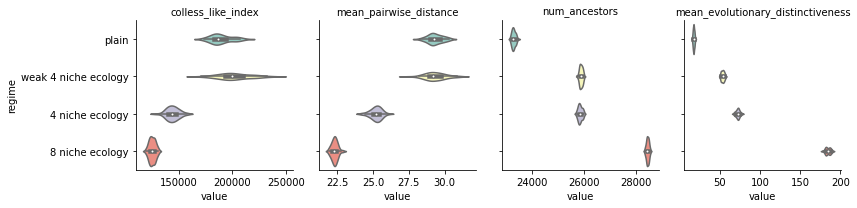

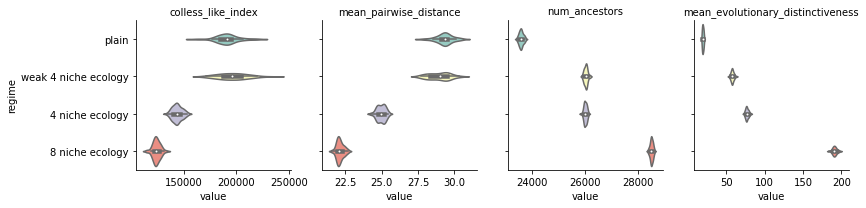

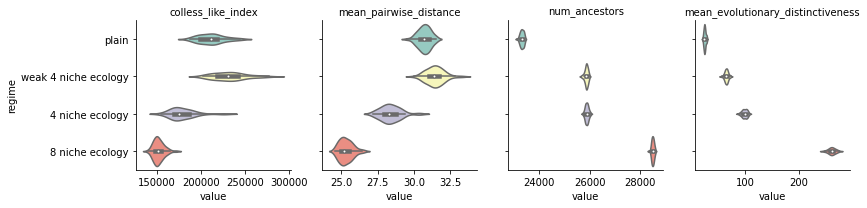

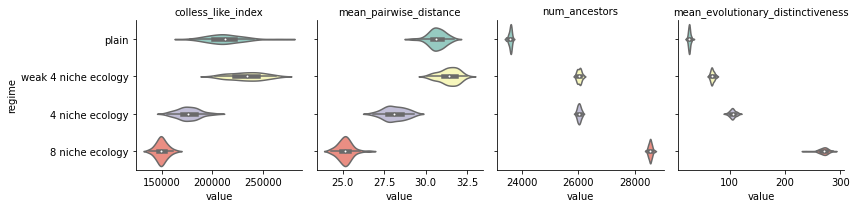

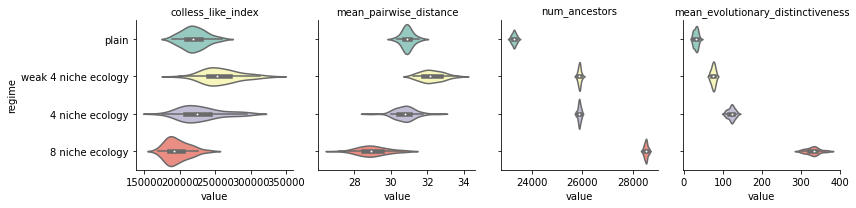

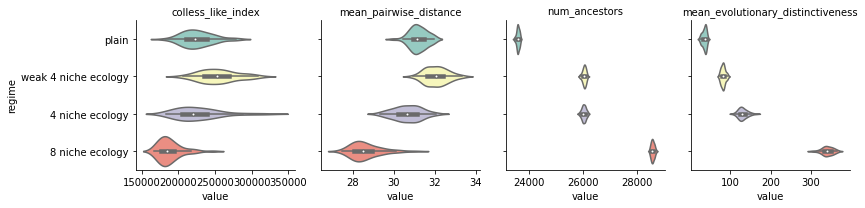

In [18]:
def make_do_plot(plotter):
    def do_plot(data, col, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            sharex=False,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "plain",
                "weak 4 niche ecology",
                "4 niche ecology",
                "8 niche ecology",
            ],
            palette=sns.color_palette("Set3", 4),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        x="value",
        y="regime",
        teeplot_outattrs={
            **{
                "nuisance": "spatial-structure",
            },
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
        },
    )


# stats: kruskal wallace among regimes


In [19]:
records = []
for phylometric in phylometrics:
    for group, group_df in df[(df["a"] == "collapsed-phylogeny")].groupby(
        sensitivity_analysis_variables,
        as_index=False,
    ):
        kw_result, n = scipy_stats.kruskal(
            *(
                quality_series
                for quality, quality_series in group_df.groupby(["regime"])[
                    phylometric
                ]
            )
        ), min(group_df.groupby(["regime"]).count()["a"])
        records.append(
            {
                **{
                    "n": n,
                    "N": len([*group_df.groupby(["regime"])]),
                    "phylometric": phylometric,
                },
                **dict(zip(["statistic", "p"], kw_result)),
                **dict(zip(sensitivity_analysis_variables, group)),
            }
        )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            sensitivity_analysis_variables,
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-spatial-nuisance-kwallis+ext=.csv",
        index=False,
    )


,n,N,phylometric,statistic,p,epoch,mut_distn
0,50,4,colless_like_index,172.713564,3.302345e-37,0,np.random.exponential
1,50,4,mean_pairwise_distance,167.921194,3.576287e-36,0,np.random.exponential
2,50,4,num_ancestors,169.633655,1.526701e-36,0,np.random.exponential
3,50,4,mean_evolutionary_distinctiveness,186.567164,3.366062e-40,0,np.random.exponential
4,50,4,colless_like_index,168.730078,2.392307e-36,0,np.random.standard_normal
5,50,4,mean_pairwise_distance,169.356466,1.752241e-36,0,np.random.standard_normal
6,50,4,num_ancestors,168.308332,2.950262e-36,0,np.random.standard_normal
7,50,4,mean_evolutionary_distinctiveness,186.567164,3.366062e-40,0,np.random.standard_normal
8,50,4,colless_like_index,167.439630,4.543457e-36,2,np.random.exponential
9,50,4,mean_pairwise_distance,175.699248,7.484610e-38,2,np.random.exponential


In [20]:
records = []
for phylometric in phylometrics:
    for group, group_df in df[(df["a"] == "collapsed-phylogeny")].groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        for regime1, regime2 in it.combinations(
            group_df["regime"].unique(), 2
        ):
            kw_result, n = scipy_stats.wilcoxon(
                *zip(
                    *zip(
                        group_df[group_df["regime"] == regime1][phylometric],
                        group_df[group_df["regime"] == regime2][phylometric],
                    )
                ),
            ), min(group_df.groupby(["regime"]).count()["a"])
            records.append(
                {
                    **{
                        "regime1": regime1,
                        "regime2": regime2,
                        "n": n,
                        "phylometric": phylometric,
                    },
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(zip(sensitivity_analysis_variables, group)),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime1", "regime2"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-allpairs-spatial-nuisance-wilcox+ext=.csv",
        index=False,
    )


,regime1,regime2,n,phylometric,statistic,p,epoch,mut_distn
0,4 niche ecology,8 niche ecology,50,colless_like_index,1.0,8.031091e-10,0,np.random.exponential
1,4 niche ecology,8 niche ecology,50,mean_pairwise_distance,0.0,7.556929e-10,0,np.random.exponential
2,4 niche ecology,8 niche ecology,50,num_ancestors,0.0,7.551805e-10,0,np.random.exponential
3,4 niche ecology,8 niche ecology,50,mean_evolutionary_distinctiveness,0.0,7.556929e-10,0,np.random.exponential
4,4 niche ecology,plain,50,colless_like_index,0.0,7.556929e-10,0,np.random.exponential
5,4 niche ecology,plain,50,mean_pairwise_distance,0.0,7.556929e-10,0,np.random.exponential
6,4 niche ecology,plain,50,num_ancestors,0.0,7.555221e-10,0,np.random.exponential
7,4 niche ecology,plain,50,mean_evolutionary_distinctiveness,0.0,7.556929e-10,0,np.random.exponential
8,4 niche ecology,weak 4 niche ecology,50,colless_like_index,0.0,7.556929e-10,0,np.random.exponential
9,4 niche ecology,weak 4 niche ecology,50,mean_pairwise_distance,0.0,7.556929e-10,0,np.random.exponential


# reconstructed phylogenetic data


In [21]:
df["quality"] = df.apply(
    lambda row: {
        ("reconstructed-tree", 3.0): "33% resolution",
        ("reconstructed-tree", 10.0): "10% resolution",
        ("reconstructed-tree", 30.0): "3% resolution",
        ("reconstructed-tree", 100.0): "1% resolution",
        ("collapsed-phylogeny", 0): "perfect resolution",
    }.get(
        tuple(row[["a", "resolution"]].fillna(0)),
        np.nan,  # default
    ),
    axis="columns",
)
df["quality"].unique()


array(['perfect resolution', '10% resolution', '1% resolution',
       '3% resolution', '33% resolution'], dtype=object)

In [22]:
melted_df = df.melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime", "a", "quality"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


,num_niches,resolution,epoch,mut_distn,regime,a,quality,variable,value,phylometric
0,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,245694.126217,colless_like_index
1,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,229733.780163,colless_like_index
2,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,233461.802088,colless_like_index
3,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,262782.396217,colless_like_index
4,4,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,260748.492189,colless_like_index
...,...,...,...,...,...,...,...,...,...,...
23991,8,3.0,7,np.random.exponential,8 niche ecology,reconstructed-tree,33% resolution,mean_evolutionary_distinctiveness,313.221619,mean_evolutionary_distinctiveness
23992,8,30.0,7,np.random.exponential,8 niche ecology,reconstructed-tree,3% resolution,mean_evolutionary_distinctiveness,336.758774,mean_evolutionary_distinctiveness
23993,8,100.0,7,np.random.exponential,8 niche ecology,reconstructed-tree,1% resolution,mean_evolutionary_distinctiveness,309.332581,mean_evolutionary_distinctiveness
23994,8,10.0,7,np.random.exponential,8 niche ecology,reconstructed-tree,10% resolution,mean_evolutionary_distinctiveness,305.019302,mean_evolutionary_distinctiveness


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+nuisance=spatial-structure+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+nuisance=spatial-structure+row=regime+viz=barplot+x=value

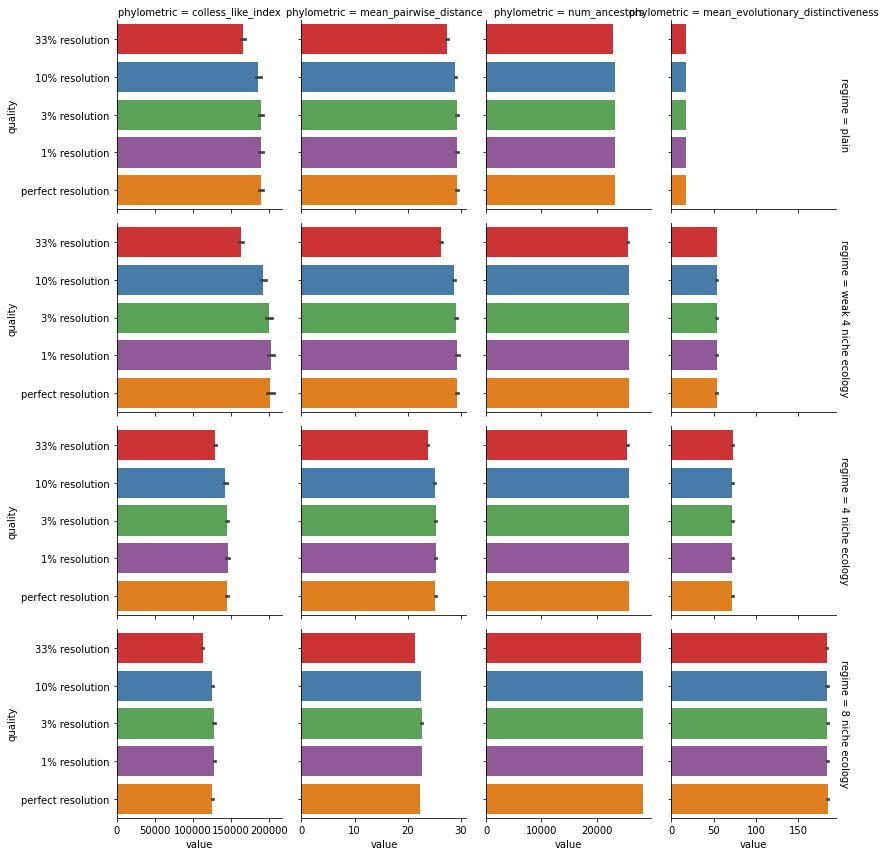

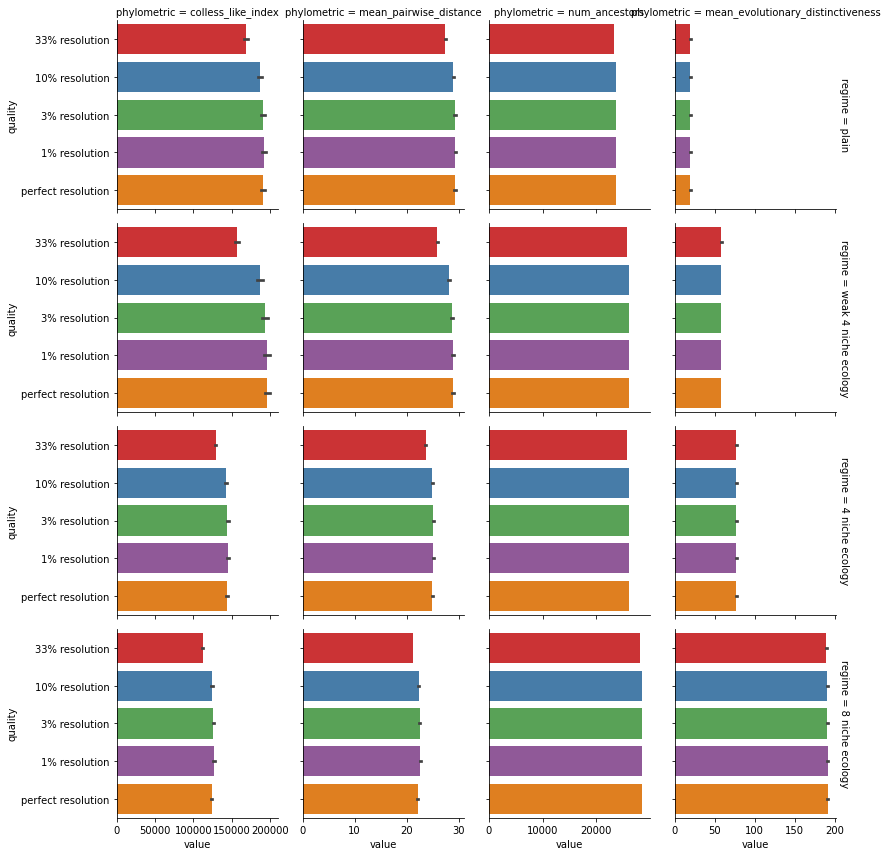

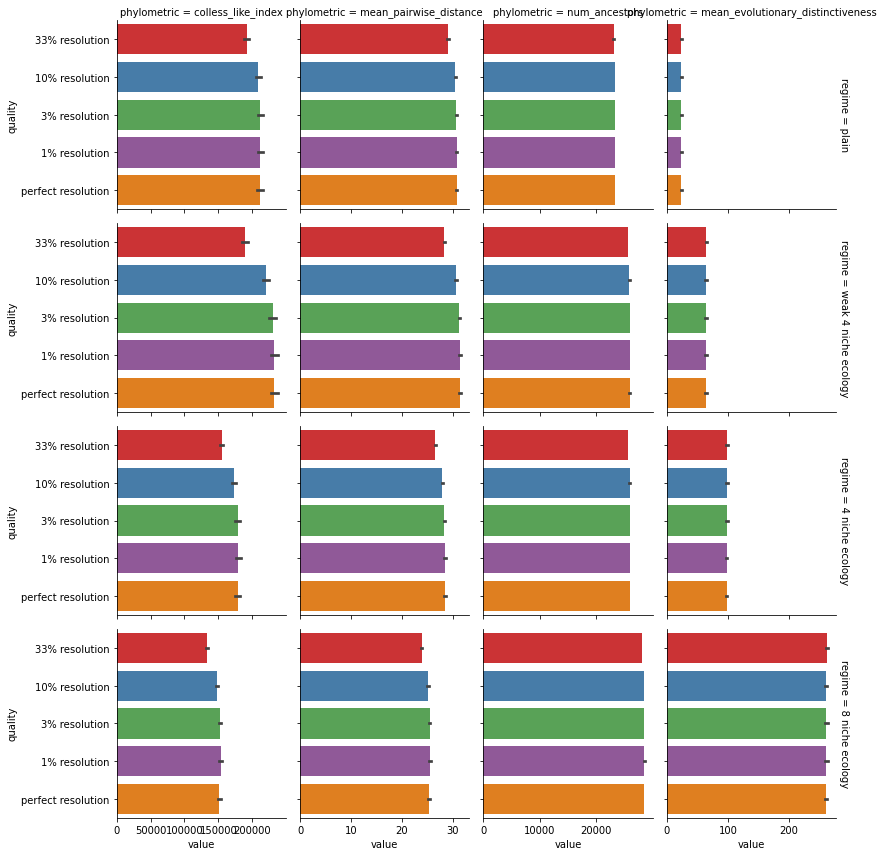

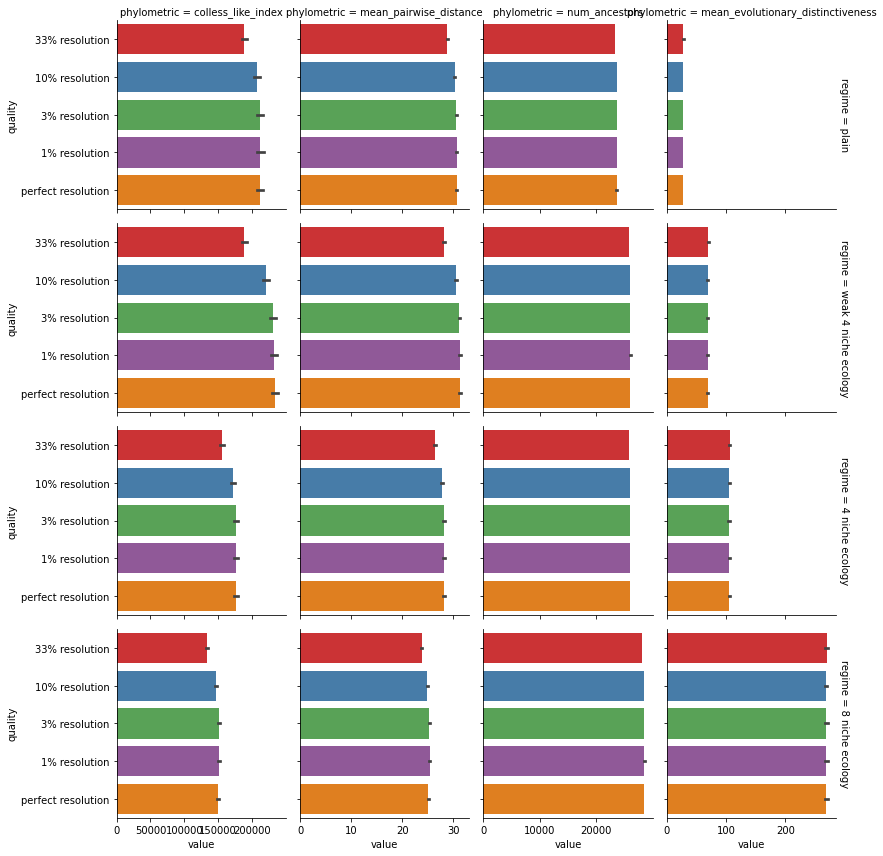

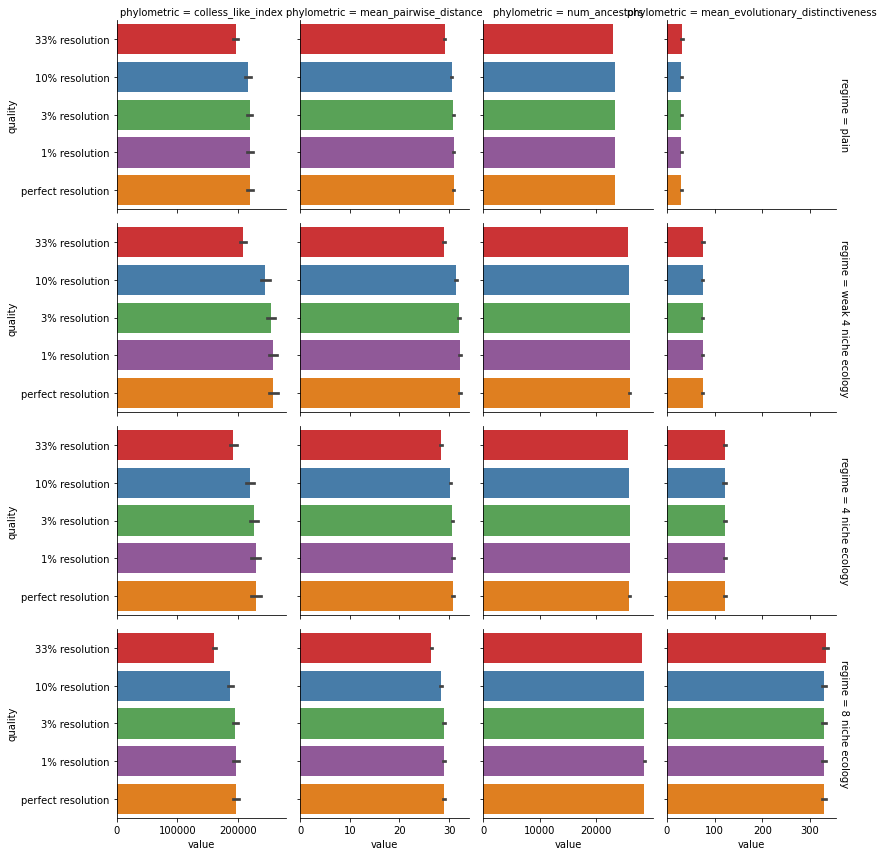

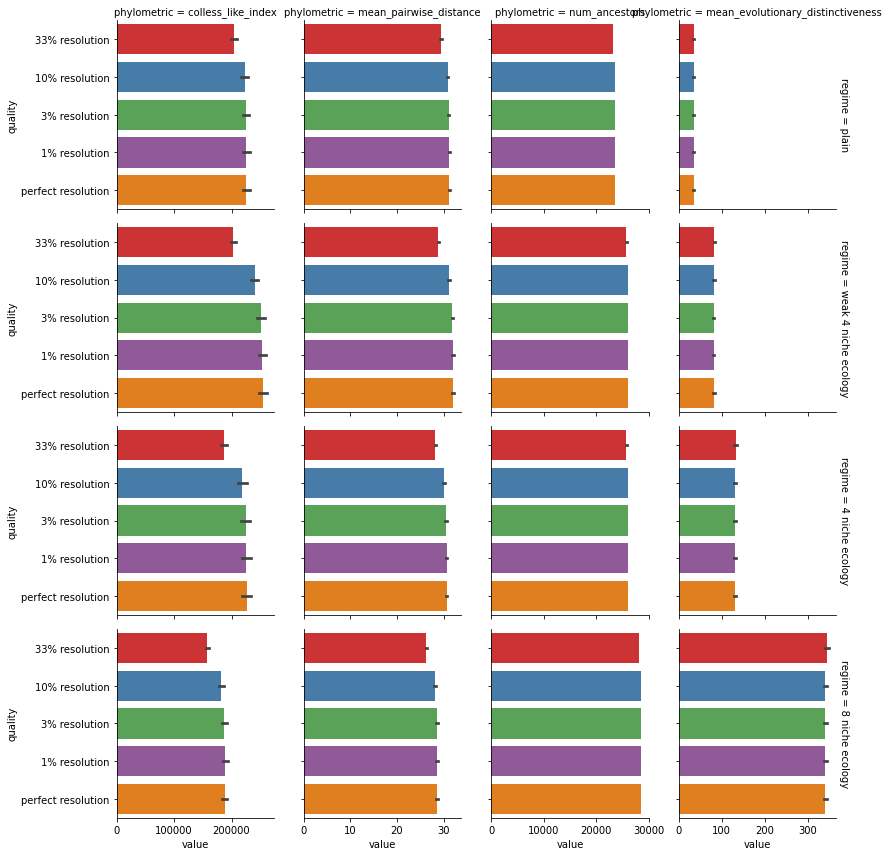

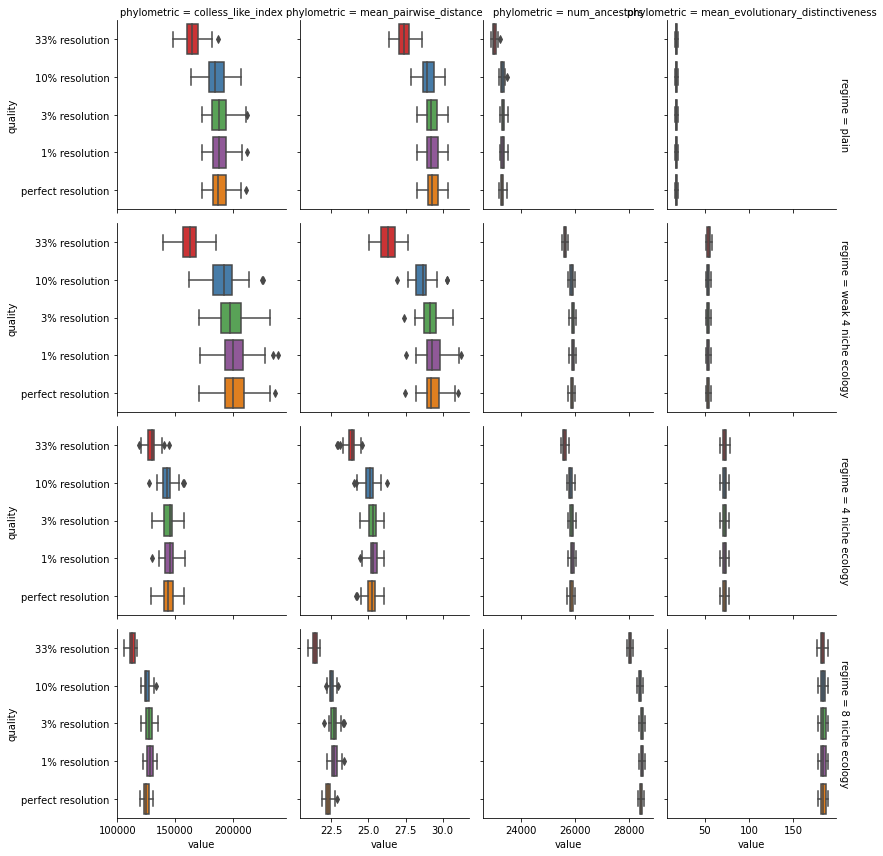

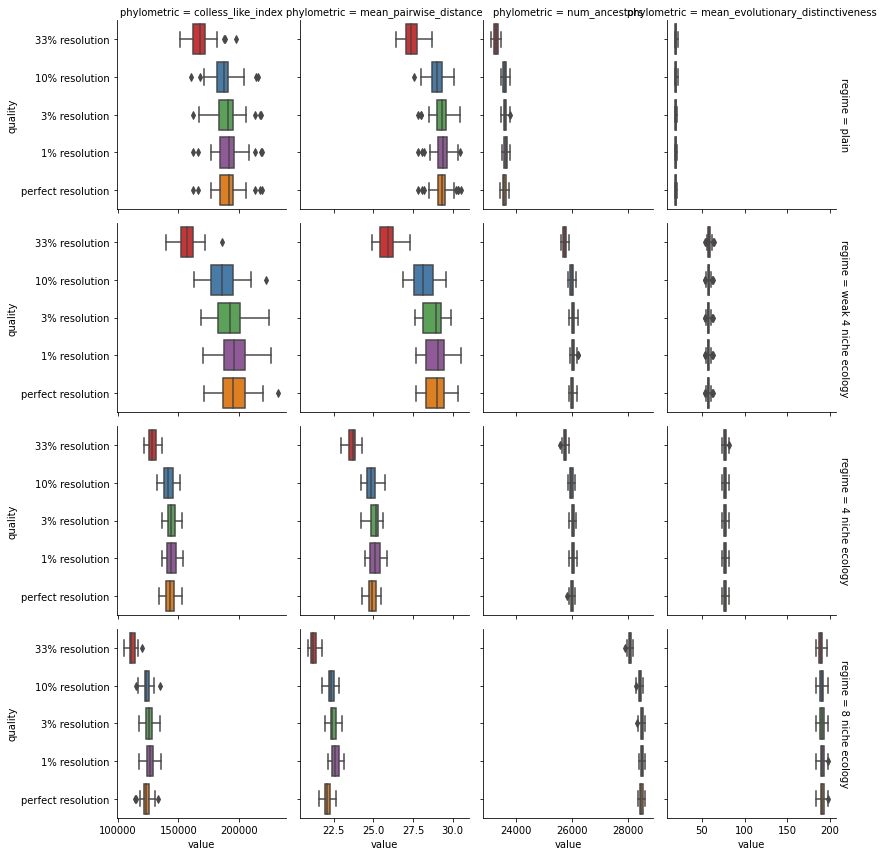

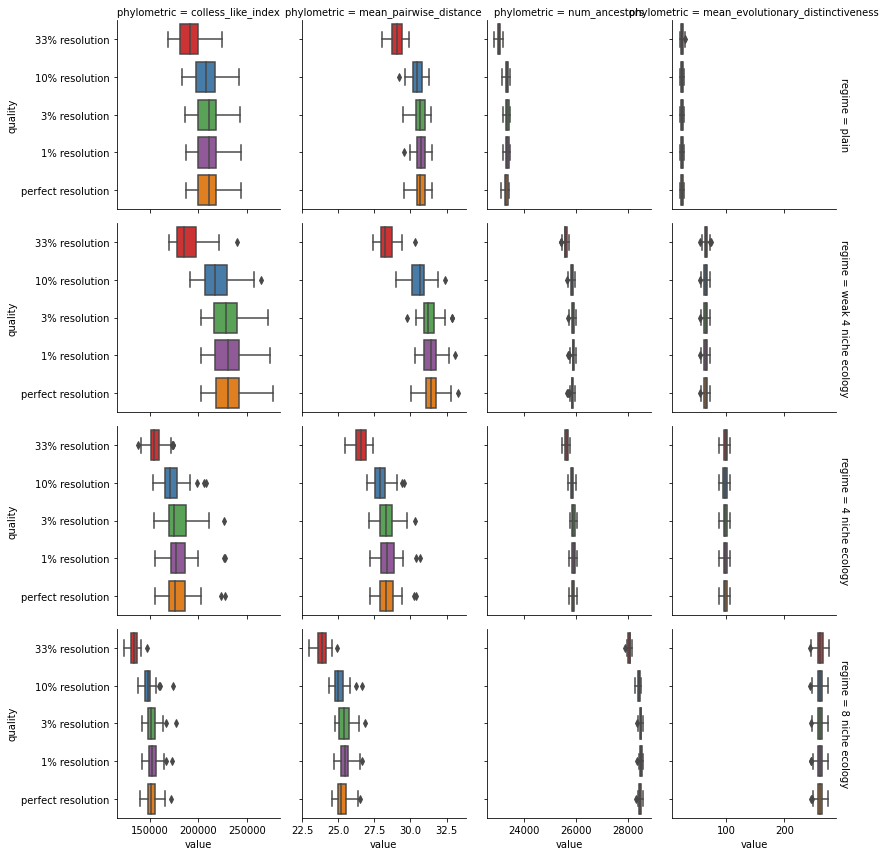

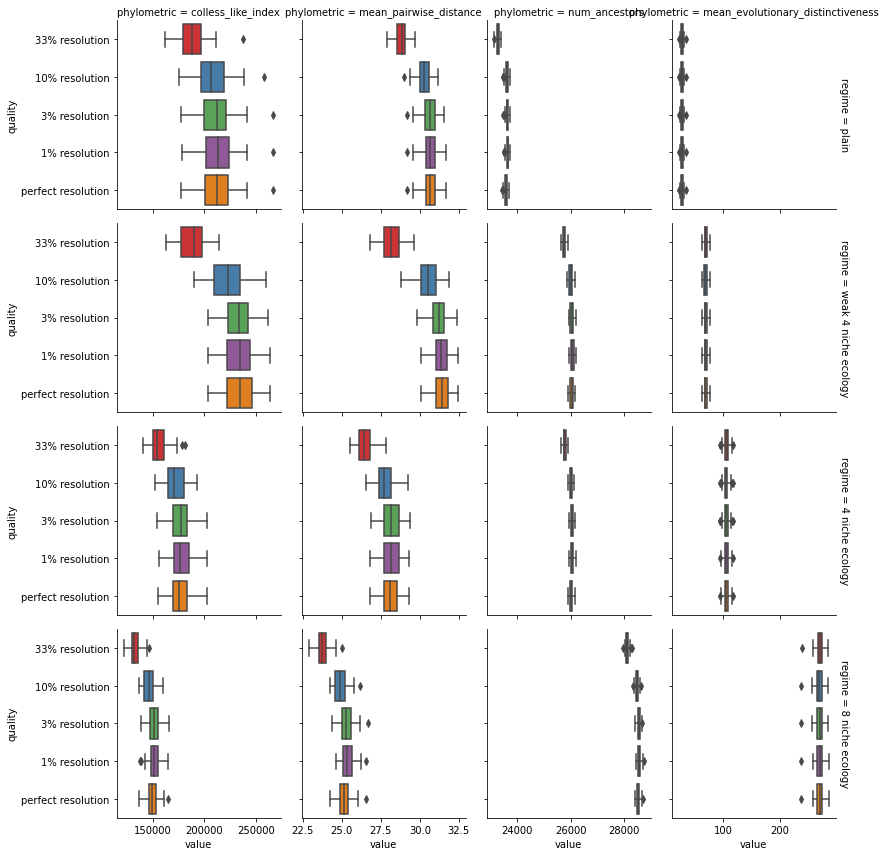

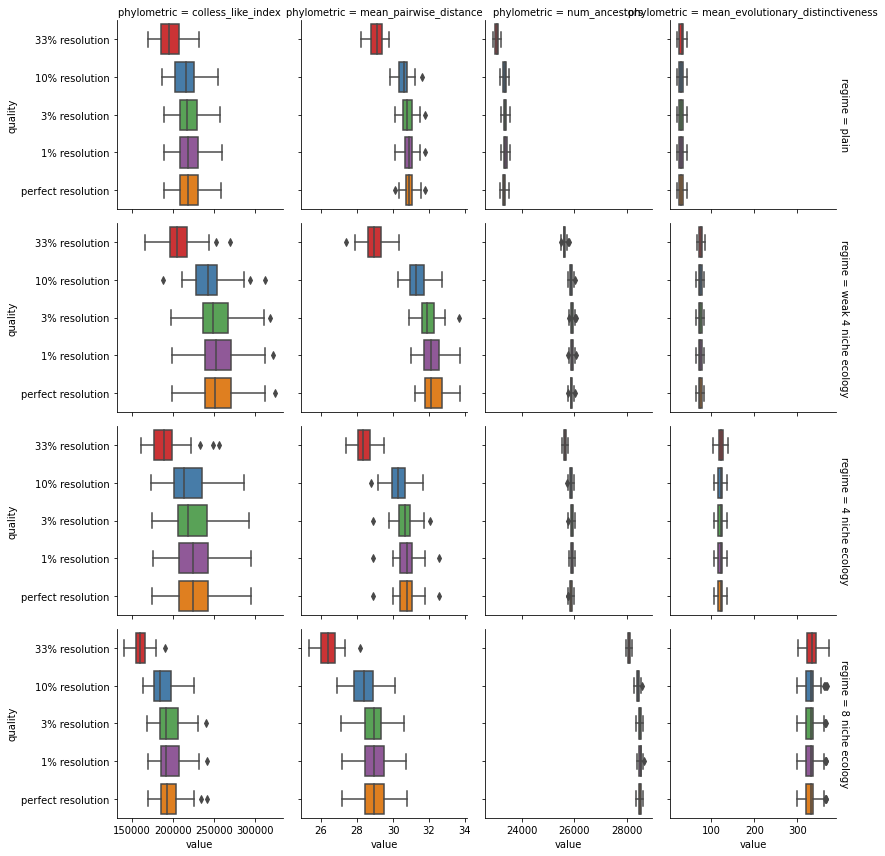

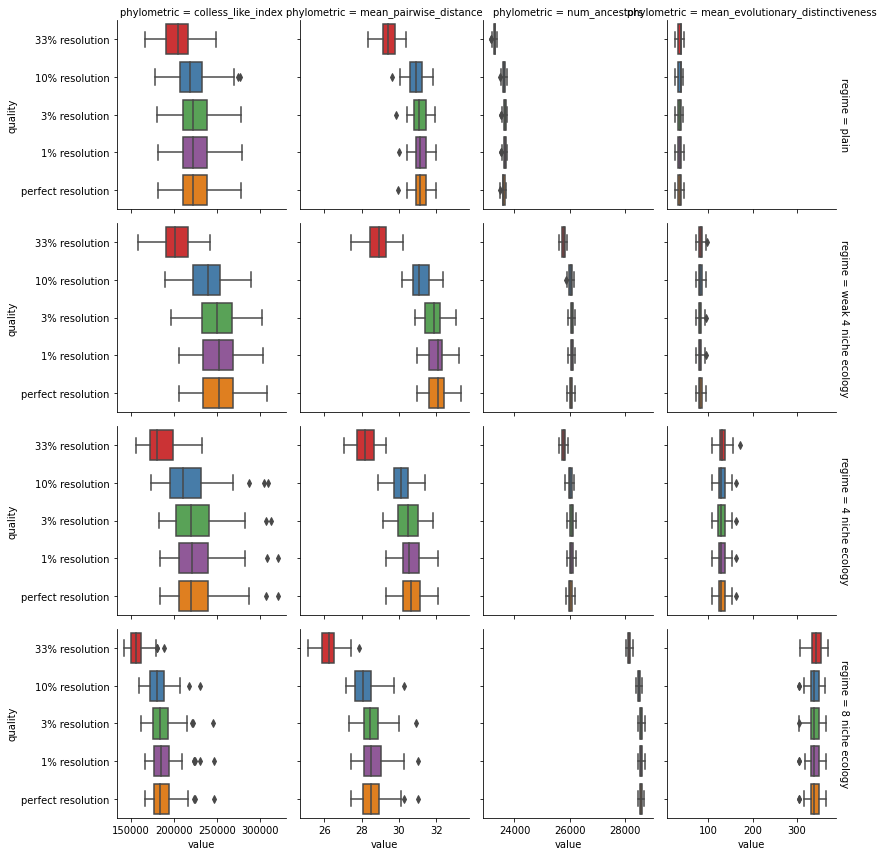

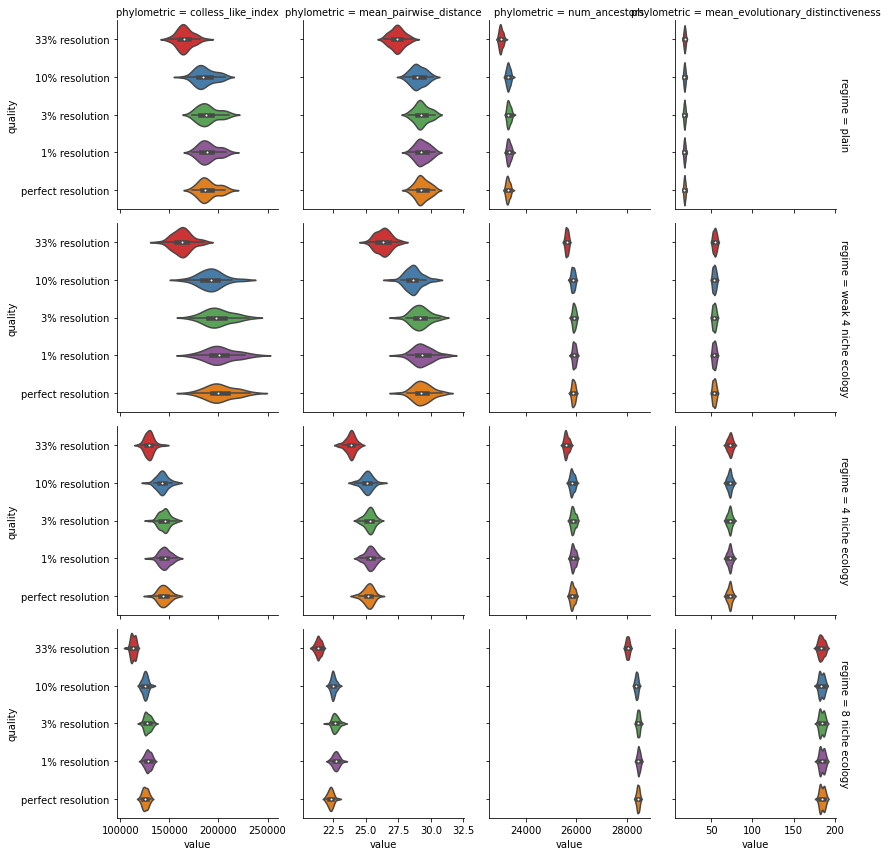

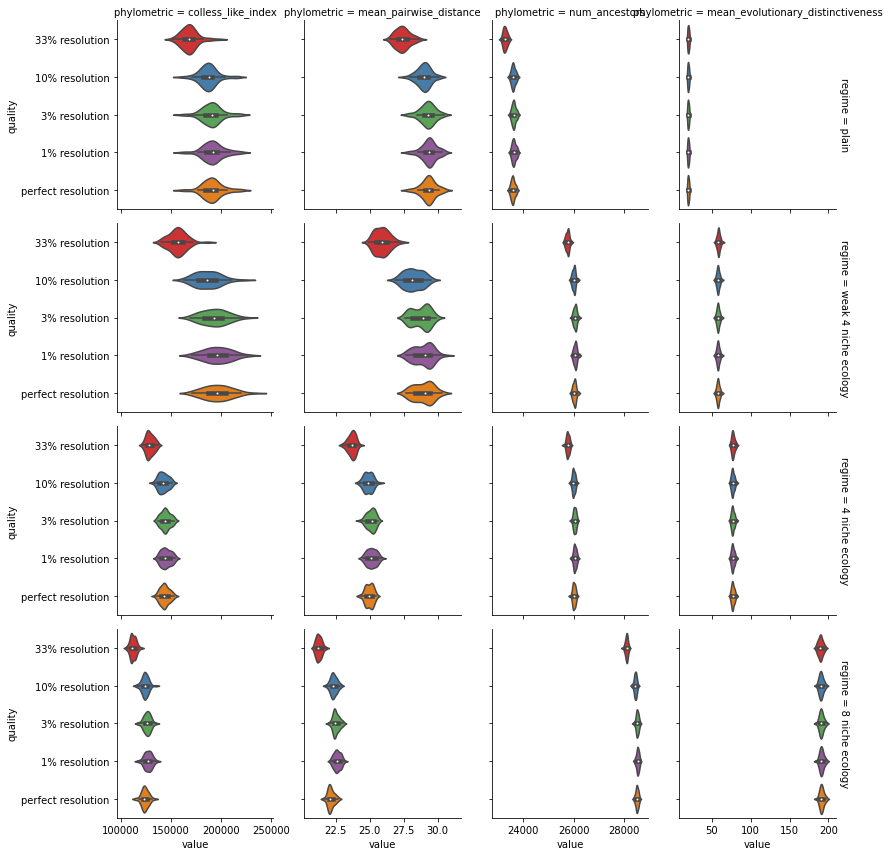

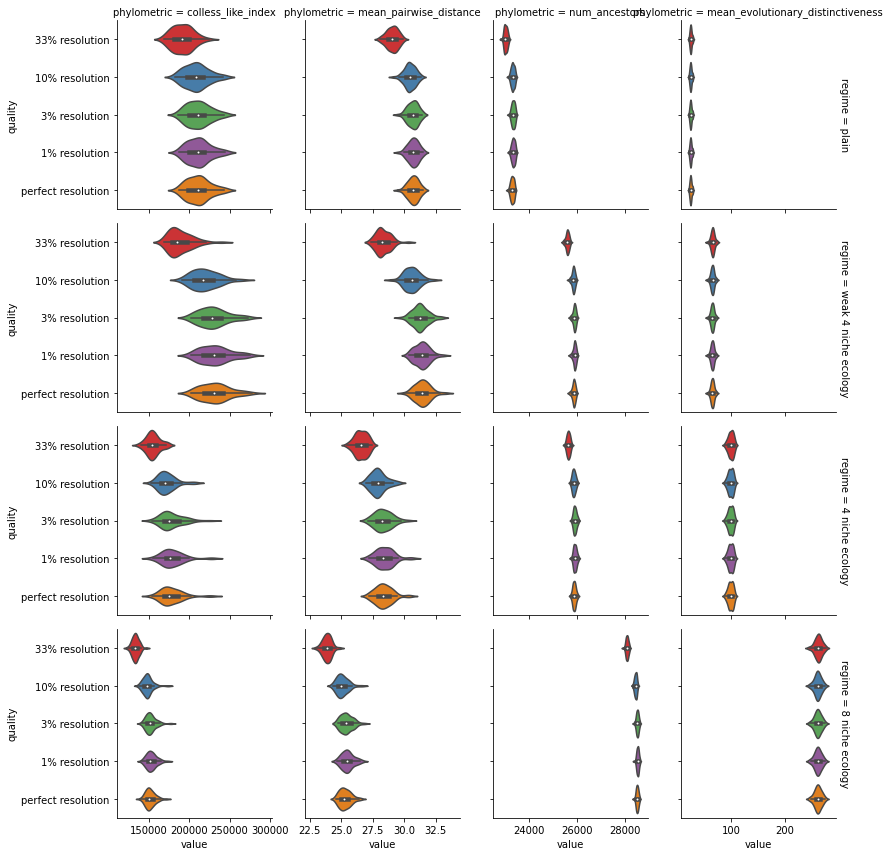

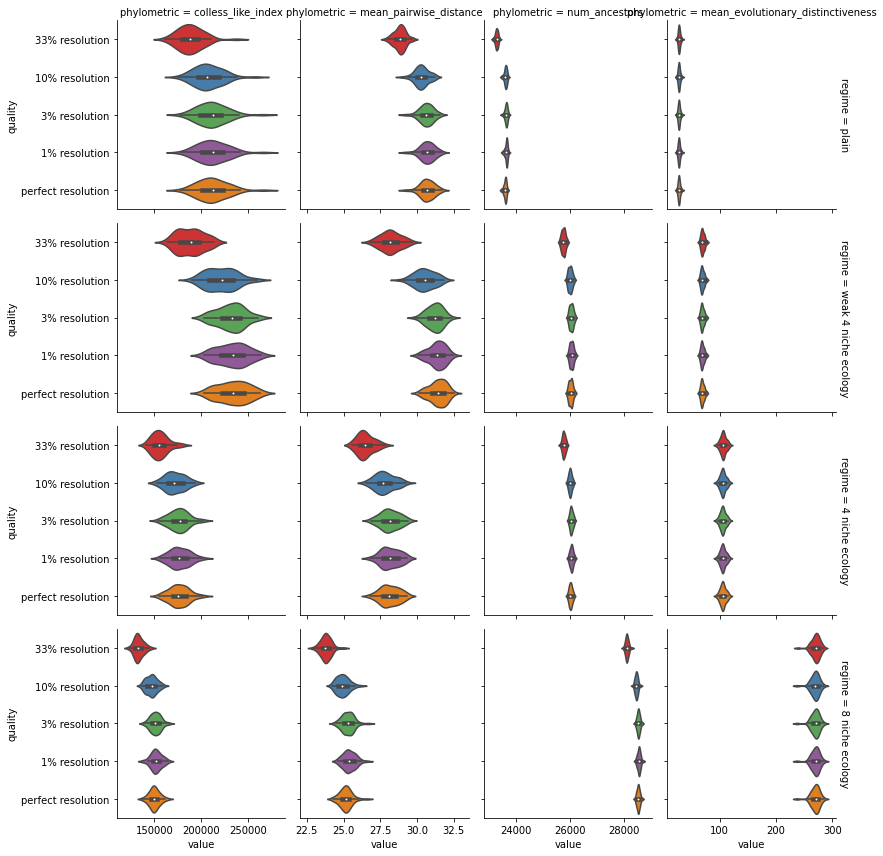

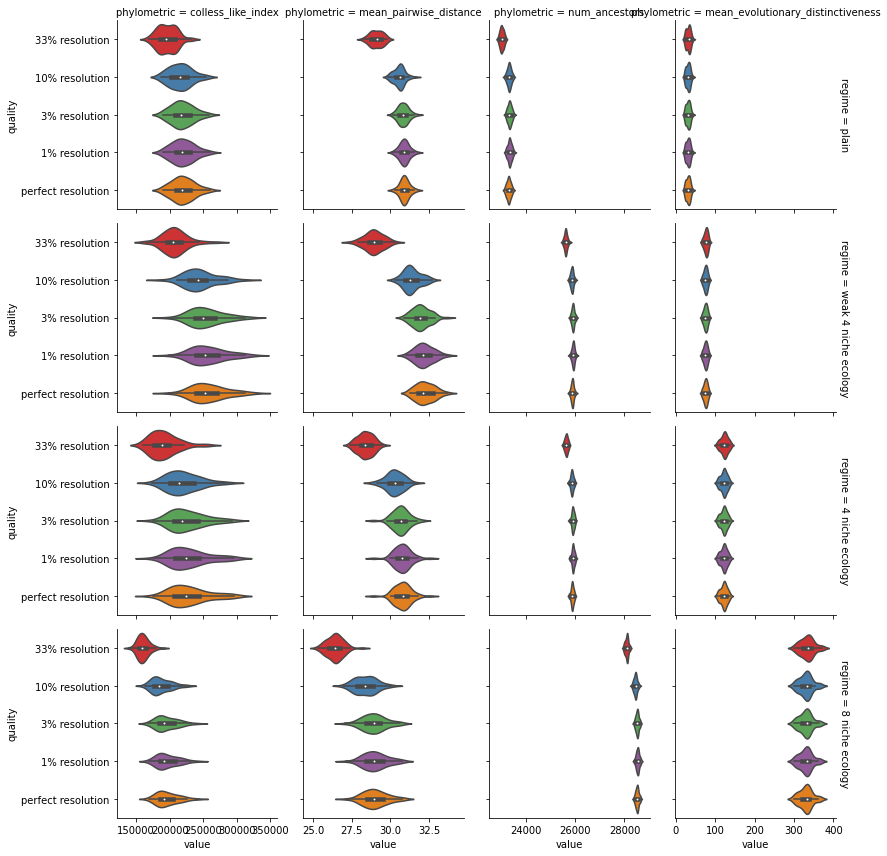

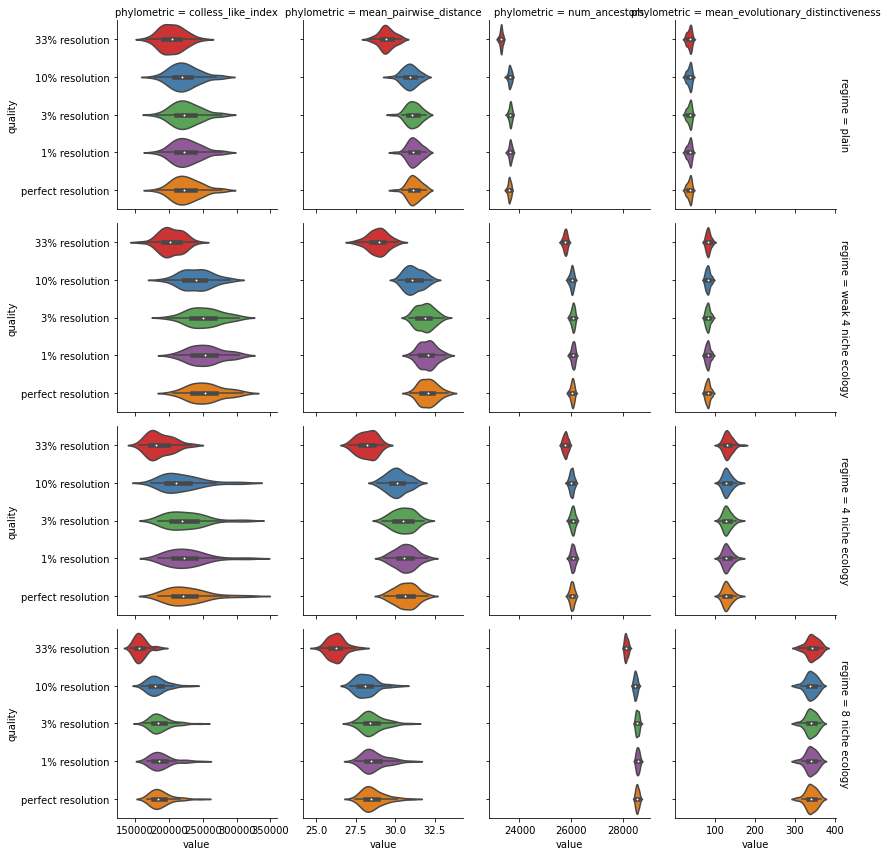

In [23]:
def make_do_plot(plotter):
    def do_plot(data, col, row, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            row=row,
            row_order=[
                "plain",
                "weak 4 niche ecology",
                "4 niche ecology",
                "8 niche ecology",
            ],
            sharex="col",
            margin_titles=True,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "33% resolution",
                "10% resolution",
                "3% resolution",
                "1% resolution",
                "perfect resolution",
            ],
            palette=sns.color_palette("Set1", 5),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        row="regime",
        x="value",
        y="quality",
        teeplot_outattrs={
            **{
                "nuisance": "spatial-structure",
            },
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
        },
    )


# stats: comparison against perfect


In [24]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        ["regime", *sensitivity_analysis_variables], as_index=False
    ):
        for quality in group_df["quality"].unique():
            if quality == "perfect resolution":
                continue
            kw_result, n = scipy_stats.wilcoxon(
                *zip(
                    *zip(
                        group_df[group_df["quality"] == "perfect resolution"][
                            phylometric
                        ],
                        group_df[group_df["quality"] == quality][phylometric],
                    )
                ),
            ), min(group_df.groupby(["quality"]).count()["a"])
            records.append(
                {
                    **{"quality": quality, "n": n, "phylometric": phylometric},
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(
                        zip(["regime", *sensitivity_analysis_variables], group)
                    ),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime", "phylometric"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-resolutions-allpairs-wilcox-spatial-nuisance+ext=.csv",
        index=False,
    )


,quality,n,phylometric,statistic,p,regime,epoch,mut_distn
0,33% resolution,50,colless_like_index,1.0,8.031091e-10,4 niche ecology,0,np.random.exponential
1,10% resolution,50,colless_like_index,497.0,1.750083e-01,4 niche ecology,0,np.random.exponential
2,1% resolution,50,colless_like_index,559.0,4.485813e-01,4 niche ecology,0,np.random.exponential
3,3% resolution,50,colless_like_index,602.0,7.318306e-01,4 niche ecology,0,np.random.exponential
4,33% resolution,50,mean_evolutionary_distinctiveness,514.0,2.331907e-01,4 niche ecology,0,np.random.exponential
5,10% resolution,50,mean_evolutionary_distinctiveness,606.0,7.610683e-01,4 niche ecology,0,np.random.exponential
6,1% resolution,50,mean_evolutionary_distinctiveness,631.0,9.499685e-01,4 niche ecology,0,np.random.exponential
7,3% resolution,50,mean_evolutionary_distinctiveness,580.0,5.788512e-01,4 niche ecology,0,np.random.exponential
8,33% resolution,50,mean_pairwise_distance,0.0,7.556929e-10,4 niche ecology,0,np.random.exponential
9,10% resolution,50,mean_pairwise_distance,482.0,1.333336e-01,4 niche ecology,0,np.random.exponential


# error signfiicance heatmap


teeplots/./epoch=0+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=0+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png
teeplots/./epoch=0+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=0+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png
teeplots/./epoch=2+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=2+hue=quality-threshold+mut_distn=np.random.exponential+nuisance=spatial-structure+viz=heatmap+x=regime+y=phylometric+ext=.png
teeplots/./epoch=2+hue=quality-threshold+mut_distn=np.random.standard_normal+nuisance=spatial-structure+viz=heatmap+x=regime+y=p

,regime,phylometric,quality threshold,epoch,mut_distn
0,4 niche ecology,colless_like_index,10.0,7,np.random.standard_normal
1,4 niche ecology,mean_evolutionary_distinctiveness,33.0,7,np.random.standard_normal
2,4 niche ecology,mean_pairwise_distance,3.0,7,np.random.standard_normal
3,4 niche ecology,num_ancestors,10.0,7,np.random.standard_normal
4,8 niche ecology,colless_like_index,10.0,7,np.random.standard_normal
5,8 niche ecology,mean_evolutionary_distinctiveness,33.0,7,np.random.standard_normal
6,8 niche ecology,mean_pairwise_distance,3.0,7,np.random.standard_normal
7,8 niche ecology,num_ancestors,3.0,7,np.random.standard_normal
8,plain,colless_like_index,10.0,7,np.random.standard_normal
9,plain,mean_evolutionary_distinctiveness,33.0,7,np.random.standard_normal


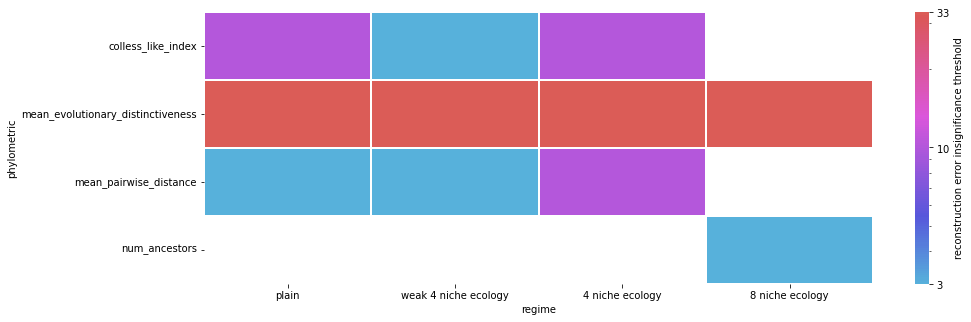

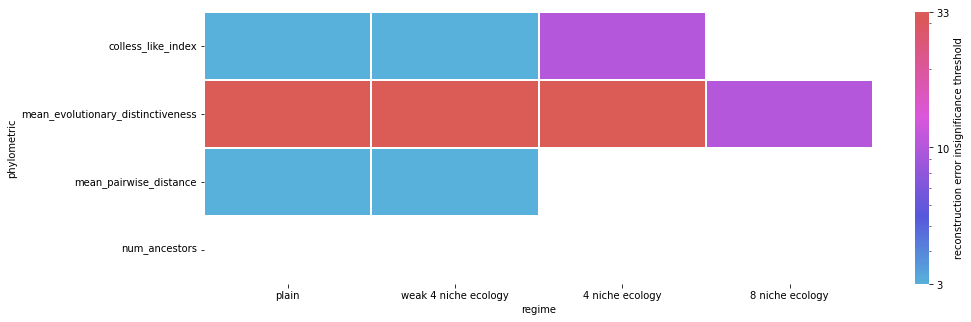

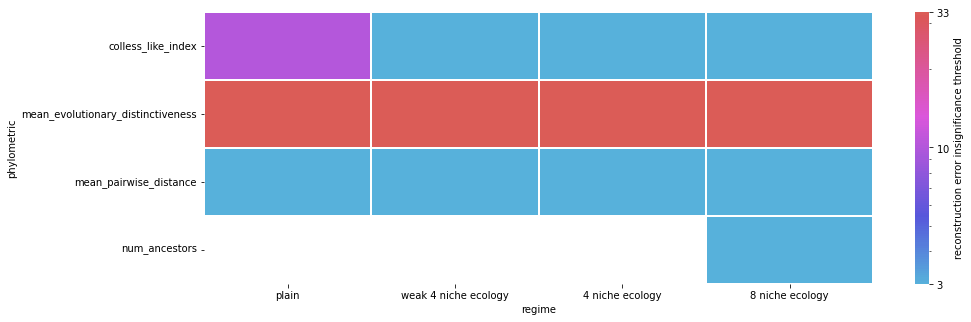

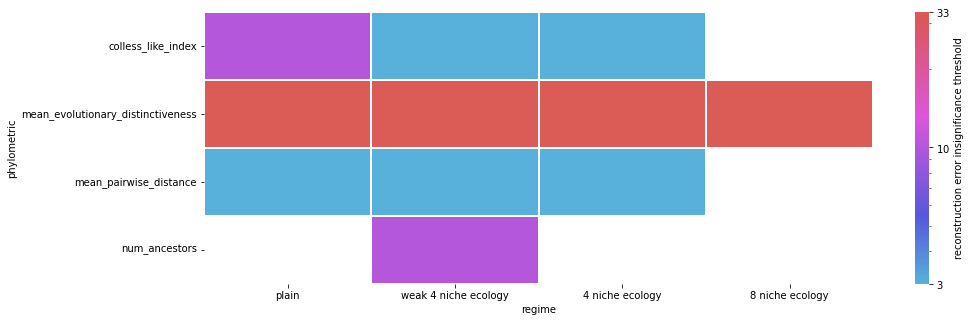

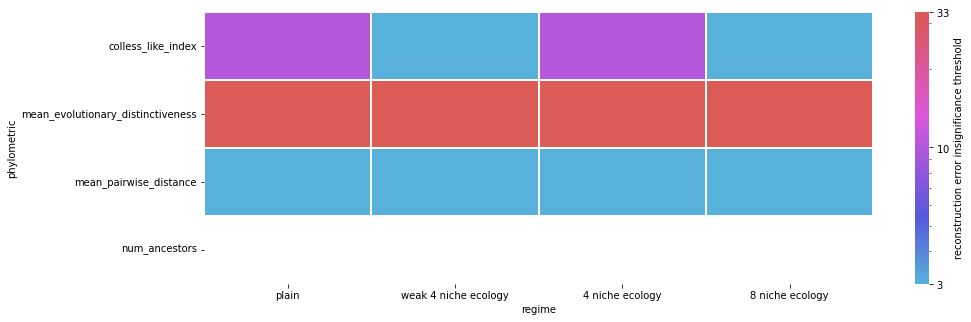

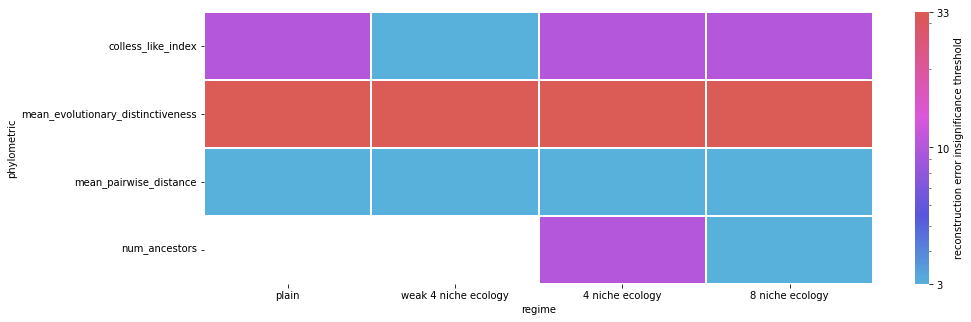

In [25]:
for group, group_df in out_df.groupby(
    sensitivity_analysis_variables, as_index=False
):
    group_df["quality threshold"] = group_df["quality"]
    group_df.loc[group_df["p"] > 0.05, "quality threshold"] = ""
    summarized_df = (
        group_df.groupby(["regime", "phylometric"])
        .agg(
            {
                "quality threshold": lambda subgroup: (
                    np.nan
                    if "1% resolution" in set(subgroup)
                    else 1
                    if "3% resolution" in set(subgroup)
                    else 3
                    if "10% resolution" in set(subgroup)
                    else 10
                    if "33% resolution" in set(subgroup)
                    else 33
                ),
                "epoch": lambda subgroup: ip.pophomogeneous(subgroup),
                "mut_distn": lambda subgroup: ip.pophomogeneous(subgroup),
            }
        )
        .reset_index()
    )

    matrix = summarized_df.pivot(
        index="phylometric",
        columns="regime",
        values="quality threshold",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak 4 niche ecology",
                "4 niche ecology",
                "8 niche ecology",
            ].index,
        )
    ]

    fig, ax = plt.subplots(figsize=(15, 5))
    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    tp.tee(
        sns.heatmap,
        matrix,
        linewidths=2,
        norm=mpl.colors.LogNorm(),
        cmap=sns.color_palette("hls", as_cmap=True),
        center=0,
        cbar_kws={
            "label": "reconstruction error insignificance threshold",
            "ticks": [1, 3, 10, 33],
            "format": formatter,
        },
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "nuisance": "spatial-structure",
                "hue": "quality-threshold",
                "x": "regime",
                "y": "phylometric",
            },
        },
    )

summarized_df
